In [7]:
import re
import numpy as np
import os
import glob
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator
import itertools
import scipy.stats

In [8]:
def logs_to_pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """

    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": [], "wall_time": []})
    try:
        event_acc = summary_iterator(path)
        for event in list(event_acc)[1:]:
            step, wall_time = event.step, pd.to_datetime(event.wall_time, unit='s')
            simple_extractor = [{"metric": v.tag, "value": v.simple_value, "step": step, 'wall_time': wall_time} for v in event.summary.value]
            event_r = pd.DataFrame(simple_extractor)
            runlog_data = pd.concat([runlog_data, event_r])
    # Dirty catch of DataLossError
    except Exception as e:
        print("Event file possibly corrupt: {}".format(path))
        print(e)
    return runlog_data

In [23]:
def extract_info_from_df(df):
    acc = []
    rt = []
    for i in range(len(df.index)):
        if 'accuracy' in df['metric'].iloc[i]:
            acc.append(df['value'].iloc[i])
            rt.append((df['wall_time'].iloc[i] - df['wall_time'].iloc[i-1]).total_seconds())
    try:
        st = df['wall_time'].iloc[0]
        et = df['wall_time'].iloc[-1]
    except:
        st = None
        et = None
    return np.mean(acc), np.mean(rt), st, et


In [10]:
def match_config_to_jobs(configs, job_files):
    pattern = r'(?<=Deploying on cluster: ).*'
    matches = []
    for job_file in job_files:
        text = open(job_file, 'r').read()
        matches += re.findall(pattern, text)
    
    list_keys = list(configs.keys())
    
    [v1, v2, v3, v4, v5] = list(configs.values())
    
    array_shape = tuple([len(v) for v in configs.values()])
    jobs_arr = np.empty(array_shape).astype('str')
    cfg_arr = np.empty(array_shape).astype('S200')
    
    counter = 0
    config_dict = {}
    for i in range(len(v1)):
        config_dict[v1[i]] = {}
        for j in range(len(v2)):
            config_dict[v1[i]][v2[j]] = {}
            for k in range(len(v3)):
                config_dict[v1[i]][v2[j]][v3[k]] = {}
                for l in range(len(v4)):
                    config_dict[v1[i]][v2[j]][v3[k]][v4[l]] = {}
                    for m in range(len(v5)):
                        config_dict[v1[i]][v2[j]][v3[k]][v4[l]][v5[m]] =\
                        matches[counter]
                        jobs_arr[i,j,k,l,m] = matches[counter]
                        cfg_arr[i,j,k,l,m] = f"{list_keys[0]}:{v1[i]} --- {list_keys[1]}:{v2[j]} --- {list_keys[2]}:{v3[k]} --- {list_keys[3]}:{v4[l]} --- {list_keys[4]}:{v5[m]}"
                        counter += 1
                        
 
    return config_dict, jobs_arr, cfg_arr

In [49]:
def job_name_to_df(root_dir, exp_prefix, jobs_arr):
    acc_arr = np.full(np.shape(jobs_arr) , None)
    rt_arr = np.full(np.shape(jobs_arr), None)
    st_arr = np.full(np.shape(jobs_arr), None)
    et_arr = np.full(np.shape(jobs_arr), None)
        
    for path, subdirs, files in os.walk(root_dir):
        for subdir in subdirs:
            if exp_prefix in subdir:
                job_in_subdir_name = np.vectorize(lambda x: x in subdir)
                jobs_loc = np.where(job_in_subdir_name(jobs_arr))
                if all(a.size > 0 for a in jobs_loc):
                    files_found = []
                    for path2, subdirs2, files2 in os.walk(os.path.join(path, subdir)):
                        files_found += [os.path.join(path2, f) for f in files2]
                    if len(files_found) >= 1:
                        df = logs_to_pandas(files_found[0])
                        acc, rt, st, et = extract_info_from_df(df)
                        acc_arr[jobs_loc] = acc
                        rt_arr[jobs_loc] = rt
                        st_arr[jobs_loc] = st
                        et_arr[jobs_loc] = et
                    if len(files_found) != 1:
                        print(f'found {len(files_found)} log files instead of 1 for {subdir}')
    return acc_arr, rt_arr, st_arr, et_arr

def reduce_array(arr):
    arr_red = arr[[0,1]]
    arr_red = arr_red[:,[0,2]]
    arr_red = arr_red[:,:,[1,2]]
    return arr_red

In [55]:
def make_sign_table_4():
    table = []
    signs = [-1,1]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    table.append([1, signs[i],signs[j],signs[k],signs[l]])
                    for comb_len in range(1,4):
                        combos = make_combinations(list(range(4)), comb_len + 1)
                        for combo in combos:
                            table_value = 1
                            for z in combo:
                                table_value *= table[-1][z]
                            table[-1].append(table_value)
    return np.array(table)



def make_combinations(lst, length):
    combinations = []
    for r in range(len(lst)+1):
        for combination in itertools.combinations(lst, r):
            if len(combination) == length:
                combinations.append(combination)
    return combinations

def anova_2k(cfgs, values):
    
    temp_values = values
    temp_values[temp_values == np.inf] = 0
    temp_values[temp_values == -np.inf] = 0
    total_mean = np.mean(temp_values)
    
    sign_table = make_sign_table_4()
    qjs = [0]*sign_table.shape[1]
    for i in range(sign_table.shape[0]):
        row_coords = tuple([int((s + 1)/2) for s in sign_table[i][1:5]])
        mean_row = np.mean(temp_values[row_coords])
        for j in range(sign_table.shape[1]):
            if mean_row > -np.inf and mean_row < np.inf:
                qjs[j] += mean_row * sign_table[i,j]
    qs = [np.sum(qjs[j])/(2**5) for j in range(len(qjs))]
    ssjs = [2**5*values.shape[-1]*qs[j]**2 for j in range(len(qs))]
    
    combinations = []
    for comb_len in range(4):
        combinations += make_combinations(list(range(4)), comb_len + 1)
    
    interactions = ['Y'] + combos_to_interaction(combinations) + ['Error']
    dofs = [1] + [2**(len(c)-1) for c in combinations] + [2**4 * (values.shape[-1] - 1)]
    
    ssy = np.sum(values**2)
    ss0 = 2**4*values.shape[-1]*total_mean**2
    sst = ssy - ss0    
    sse = np.sum([(np.mean(temp_values[:,:,:,:,i]) - total_mean)**2 for i in range(temp_values.shape[-1])])
    ss = [sst] + ssjs[1:] + [sse]
    var = [sst] + list(np.array(ss[1:])/sst*100)
    
    ms = list(np.array(ss)/np.array(dofs))
    
    f_comp = list(np.round(np.array(ms)/ms[-1],2))
    
    f_table = [scipy.stats.f.ppf(q=1-.05, dfn=dofs[i], dfd=dofs[-1]) for i in range(len(dofs)-1)] + [None]
    
    return pd.DataFrame({
        'ss':ss,
        'variation':[np.round(v,1) for v in var],
        'dof':dofs,
        'ms':ms,
        'F_comp':f_comp,
        'F_table':f_table
    }, index=interactions)


def combos_to_interaction(combinations):
    interactions = []
    for combo in combinations:
        string = ""
        letters = ["A","B","C","D"]
        for c in combo:
            string += letters[c]
        interactions.append(string)
    return interactions

In [56]:
nazar_configs = {'model':['fashion_mnist'],
                'cores':[500,1000,2000],
                'memory':[0.5,1,2],
                'parallelism':[2,3,5],
                'seed':[42,13,30]}

job_files = [r'../logs/500_27jobs/fl_server_logs.txt',
             r'../logs/1000_27jobs/fl_server_logs.txt',
             r'../logs/2000_27jobs/fl_server_logs.txt']

arnoud_configs = {'model':['mnist'],
                  'cores':[500,1000,2000],
                    'memory':[0.5,1,2],
                    'parallelism':[2,3,5],
                    'seed':[42,13,30]}

arnoud_files = [r'../logs/k_fac_1.txt',
               r'../logs/k_fac_2.txt',
               r'../logs/k_fac_3.txt']

_, jobs, cfgs = match_config_to_jobs(nazar_configs, job_files)
# _, jobs_a, cfgs_a = match_config_to_jobs(arnoud_configs, arnoud_files)

jobs = np.array([jobs[0], jobs[0]])
cfgs = np.array([cfgs[0], cfgs[0]])

acc_arr, rt_arr, st_arr, et_arr = job_name_to_df("../logs", "cloud_experiment_", jobs)

rt_reduced = reduce_array(rt_arr)
cfg_reduced = reduce_array(cfgs)
acc_reduced = reduce_array(acc_arr)

anova_df = anova_2k(cfg_reduced, rt_reduced)


/home/nlonyuk/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nlonyuk/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Parallelism')

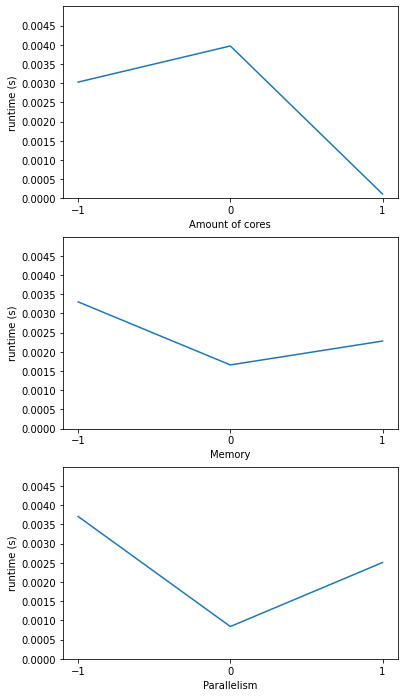

In [105]:
# print(anova_df)
plt.rcParams['figure.figsize'] = [6, 12]
                                  
fig, axes = plt.subplots(3,1)
for ax in axes:
    ax.set_ylim(0,0.005)
    ax.set_xticks([-1,0,1])
    ax.set_yticks([i * 0.0005 for i in range(int(0.005/0.0005))])
    ax.set_ylabel('runtime (s)')
    
cores_0 = rt_arr[:,0,:,:].flatten()
cores_0 = [c for c in cores_0 if not np.isnan(c) and c is not None and c > 0]
cores_1 = rt_arr[:,1,:,:].flatten()
cores_1 = [c for c in cores_1 if not np.isnan(c) and c is not None and c > 0]
cores_2 = rt_arr[:,2,:,:].flatten()
cores_2 = [c for c in cores_2 if not np.isnan(c) and c is not None and c > 0]

mem_0 = rt_arr[:,:,0,:].flatten()
mem_0 = [c for c in mem_0 if not np.isnan(c) and c is not None and c > 0]
mem_1 = rt_arr[:,:,1,:].flatten()
mem_1 = [c for c in mem_1 if not np.isnan(c) and c is not None and c > 0]
mem_2 = rt_arr[:,:,2,:].flatten()
mem_2 = [c for c in mem_2 if not np.isnan(c) and c is not None and c > 0]
    
par_0 = rt_arr[:,:,:,0].flatten()
par_0 = [c for c in par_0 if not np.isnan(c) and c is not None and c > 0]
par_1 = rt_arr[:,:,:,1].flatten()
par_1 = [c for c in par_1 if not np.isnan(c) and c is not None and c > 0]
par_2 = rt_arr[:,:,:,2].flatten()
par_2 = [c for c in par_2 if not np.isnan(c) and c is not None and c > 0]  


axes[0].plot([-1,0,1],[np.mean(cores_0),np.mean(cores_1),np.mean(cores_2)])
axes[0].set_xlabel('Amount of cores')
axes[1].plot([-1,0,1],[np.mean(mem_0),np.mean(mem_1),np.mean(mem_2)])
axes[1].set_xlabel('Memory')
axes[2].plot([-1,0,1],[np.mean(par_0),np.mean(par_1),np.mean(par_2)])
axes[2].set_xlabel('Parallelism')


In [ ]:
def MMK(cores_tasks, cores_cluster, inter_arrival_times, service_times):
    
    l = np.sum(1/np.array(inter_arrival_times))
    mu = np.sum(1/np.array(service_times)) / len(service_times)
    K = np.sum(cores_tasks)/len(cores_tasks)/cores_cluster
    rho = l/(k*mu)
    pi0 = np.sum([(k*rho)**i/(np.math.factorial(i)) for i in range(1,k)]) +
            (k*rho)**k/(np.math.factorial(k)*(1-rho))
    PQ = (k*rho)**k*pi0/(np.math.factorial(k)*(1-rho))
    
    ENQ = rho/(1-rho)*PQ
    ETQ = ENQ/l
    ET = ETQ + 1/mu
    EN = l*ET
    return EN, ENQ, ET, ETQ
    

In [106]:
def get_cores_tasks(fl_server_log):
    cores_tasks = []
    cores_map = {}
    log_text = open(fl_server_log, 'r').readlines()
    for line in log_text:
        arrivals = re.findall(r'(?<=SimulatedArrivalGenerator INFO     Arrival Arrival\()(.*)(?= arrives at)')
        for arriv in arrivals:
            task_name = re.findall(r"(?<=task_id=').*(?=')")[0]
            cores_str = re.findall(r"(?<=cores=').*(?=m',)")[0]
            cores_map[task_name] = int(cores_str)
        deployment_ids = 

SyntaxError: unexpected EOF while parsing (<ipython-input-106-7ef30c788faa>, line 3)